# Model training

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import time

import data_reader
import dataset
from plots import learning_curve_train

In [2]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [3]:
# Training and data variables

MODE = "w"
EXP_NAME = "25ep"

DATA_SET_NAME = f"data_set_x20_100%_split"
PATCH_SIZE = 512

BATCH_SIZE = 16
EPOCHS = 25

SIZE_X = PATCH_SIZE
SIZE_Y = PATCH_SIZE

#threshold = 0.05 # Loss difference for early stopping

In [4]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init():
    global net, loss_function, scheduler, optimizer, MODEL_NAME

    net = torchvision.models.resnet18(pretrained=True).to(device)

    #print(f"Loading {MODEL_NAME}")
    #net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading
    
    for param in net.parameters():
        param.requires_grad = False # Freezing the convolutional layers 

    net.fc = nn.Sequential(
                  nn.Dropout(p=0.5),  
                  nn.Linear(512, 3)
                #nn.Linear(512, 3),
                #nn.ReLU(inplace=True),
                #nn.Linear(128, 3),
                #nn.Softmax(dim = -1)
                ).to(device)

    for param in net.fc.parameters():
        param.requires_grad = True

    #for param in net.layer3.parameters():
    #    param.requires_grad = True
    
    for param in net.layer4[1].parameters():
        param.requires_grad = True # Unfreezing the last residual block

    net.fc.apply(init_weights) # Xavier init

    n_params = sum(p.numel() for p in net.fc.parameters())# + sum(p.numel() for p in net.layer4[1].parameters())
    print("Number of free parameters: ", n_params)

    #Hyperparameters:
    learning_rate = 1E-4 # LR
    loss_function = nn.CrossEntropyLoss()  # Loss
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)# Optimizer
    lambda1 = lambda epoch: 0.8 ** epoch # Scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


In [5]:
def fwd_pass(X, y, train=False):
# IMPORTANTE, TRAIN = FALSE PARA QUE NO ENTRENE CON EL TEST DATA ESTO ES PARA PODER HACER TEST MIENTRAS ENTRENO Y VALIDO, 
# SE ESPERA QUE LA EXACTITUD EN EL TEST DE VALIDACIÓN SEA MENOR
    if train: 
        net.zero_grad()
        
    # NORMALIZATION
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = torchvision.transforms.Normalize(mean=mean, std=std)

    for i, x in enumerate(X):
        X[i] = normalize(X[i]/255) # Np array

    outputs = net(X)
    
    y_pred = [torch.argmax(i) for i in outputs.cpu()]
    y_true = [torch.argmax(i) for i in y.cpu()]

    #acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    conf_m = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    acc = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1 = sklearn.metrics.f1_score(y_true, y_pred, average="macro")
    auc = 0 #sklearn.metrics.roc_auc_score(y_true, y_pred, average= "micro", multi_class="ovr") #!!!!

    if train:
        loss.backward() # Calculate gradients using backprop
        optimizer.step() # Updates W and b using previously calculated gradients

    return [acc, loss, conf_m, f1, auc]

In [6]:
def train():
  global net, loss_function, scheduler, optimizer, train_set, val_set, MODEL_NAME, EPOCHS
  
  print(MODEL_NAME)
  patience = 0

  with open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss, f1, auc = 0, 0, 0, 0
      val_acc, val_loss, val_f1, val_auc = 0, 0, 0, 0
      conf_m, val_conf_m = np.zeros((3,3)), np.zeros((3,3))

      print("\nEPOCH: ", epoch+1)

      n_patches = sum(len(batch[0]) for batch in iter(train_dataloader))

      for batch_X, batch_y in tqdm(iter(train_dataloader)):
         # Number of patches in dataloader
        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0,3,2,1), batch_y.type(torch.FloatTensor).to(device) 
        
        net.train() # Making sure that the model is in training mode
        
        performance_metrics = fwd_pass(batch_X, batch_y, train=True)
        acc_aux, loss_aux, conf_m_aux, f1_aux, auc_aux = performance_metrics[0], performance_metrics[1], performance_metrics[2], performance_metrics[3], performance_metrics[4]
        acc += acc_aux*(len(batch_X)/n_patches) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        loss += loss_aux*(len(batch_X)/n_patches)
        conf_m += conf_m_aux
        f1 += f1_aux*(len(batch_X)/n_patches)
        auc += auc_aux*(len(batch_X)/n_patches)

      for batch_X, batch_y in tqdm(iter(val_dataloader)):

        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device)

        net.eval() # Making sure that the model is not training and deactivate droptout
        
        with torch.no_grad(): # Disable all computations, works together with net.eval()
          performance_metrics = fwd_pass(batch_X, batch_y, train=False)
          
        acc_aux, loss_aux, conf_m_aux, f1_aux, auc_aux = performance_metrics[0], performance_metrics[1], performance_metrics[2], performance_metrics[3], performance_metrics[4]  
        val_acc += acc_aux*(len(batch_X)/len(val_set)) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        val_loss += loss_aux*(len(batch_X)/len(val_set))
        val_conf_m += conf_m_aux
        val_f1 += f1_aux*(len(batch_X)/len(val_set))
        val_auc += auc_aux*(len(batch_X)/len(val_set))
        
      print("Val loss: ", val_loss.item(), " Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc, " Train acc: ", acc, "\n")
      print("Val AUC: ", val_auc, " Train AUC: ", auc)
      print("Val f1: ", val_f1, " Train f1: ", f1, "\n")
      print("Val CONF: \n", val_conf_m, "\nTrain CONF: \n", conf_m, "\n")

      conf_m = f"{conf_m[0][0]}+{conf_m[0][1]}+{conf_m[1][0]}+{conf_m[1][1]}"
      val_conf_m = f"{val_conf_m[0][0]}+{val_conf_m[0][1]}+{val_conf_m[1][0]}+{val_conf_m[1][1]}"
    
      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{conf_m},{round(float(auc),4)},")
      f.write(f"{round(float(val_acc),3)},{round(float(val_loss),4)},{val_conf_m}, {round(float(val_auc),4)}\n")
      f.write("\n\n")

      # Early stopping, if the difference between loss and validation loss 
      # is bigger than the threshold for 3 epochs in a row training is stopped
      if val_loss.item()>loss.item():#> threshold:
        patience +=1
      else:
        patience = 0

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

      if patience >= 7:
        print("Stopping early: ")
        break

    torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")

In [7]:
# Choosing only the images from the according splits (10CV)

SPLITS = 1 # Number of iterations > n_splits
n_splits = 3 # Number of splits to use

for SPLIT in range(SPLITS):
    MODEL_NAME = EXP_NAME + f"{SPLIT}"

    TRAIN_SPLITS = list(range(n_splits))
    # We take out the SPLIT and SPLIT+1 sets for val and testing
    if SPLIT == n_splits: # For the final split for validation we take the firs one for test
        TRAIN_SPLITS.remove(0) 
    else:
        TRAIN_SPLITS.remove(SPLIT+1)
    TRAIN_SPLITS.remove(SPLIT)

    train_set = dataset.PatchDataset([], [], [])
    val_set = dataset.PatchDataset([], [], [])
    test_set = dataset.PatchDataset([], [], [])

    # Loading training splits:
    for i in TRAIN_SPLITS:
        print(f"Loading training split: {i}")
        SPLIT_NAME = DATA_SET_NAME + f"{i}"
        
        X_, y_, _ , patch_ids_ = data_reader.read_lmdb(f"D:/data/WSI/COAD/patches/{SPLIT_NAME}")

        train_set.inputs.extend(X_)
        train_set.labels.extend(y_)
        train_set.case_ids.extend(patch_ids_)

    # Random oversampler

    negative =  [i[0] for i in train_set.labels]
    coad =  [i[1] for i in train_set.labels]
    read =  [i[2] for i in train_set.labels]

    class_sample_count = np.array([sum(negative) , sum(coad), sum(read)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[np.argmax(t)] for t in train_set.labels])
    samples_weight = torch.from_numpy(samples_weight) # Probability for a sample to be sampled
    #samples_weight = torch.tensor([1/len(samples_weight)]*len(samples_weight))
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), int(3*sum(negative)))#, replacement=False) #int(len(train_set)))#
    # Will take len(samples_weight) number of samples, this can be changed

    # Creating DataLoader
    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
    
    print(f"Patches for training: {len(train_set)}\n")
    
    # Loading validation splits:
    SPLIT_NAME = DATA_SET_NAME + f"{SPLIT}"

    print(f"Loading validation split: {SPLIT}")

    X_, y_, _ , patch_ids_ = data_reader.read_lmdb(f"D:/data/WSI/COAD/patches/{SPLIT_NAME}")

    val_set.inputs.extend(X_)
    val_set.labels.extend(y_)
    val_set.case_ids.extend(patch_ids_)

    val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for validation: {len(val_set)}\n")

    """
    # Loading test splits:
    if SPLIT == n_splits:
        SPLIT_NAME = DATA_SET_NAME + f"{0}"
        print(f"Loading test split: {0}")
    else:
        SPLIT_NAME = DATA_SET_NAME + f"{SPLIT+1}"
        print(f"Loading test split: {SPLIT+1}")

    X_, y_, _ , _ = data_reader.read_lmdb(f"D:/data/WSI/COAD/patches/{SPLIT_NAME}")

    test_set.inputs.extend(X_)
    test_set.labels.extend(y_)

    test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for test: {len(test_set)}\n")
    """
    init()

    train()

    del train_set, val_set, test_set


Loading training split: 2
Read lmdb
Patches for training: 26216

Loading validation split: 0
Read lmdb
Patches for validation: 24849

Number of free parameters:  1539
25ep0

EPOCH:  1


c:\Users\Alejandro\anaconda3\envs\openslide\lib\site-packages\torch\utils\data\_utils\collate.py:146: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])


  0%|          | 0/1554 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

Val loss:  0.9703620076179504  Train loss:  0.8741448521614075 

Val acc:  0.6267053000120725  Train acc:  0.6732410127290545 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.291024308761459  Train f1:  0.6518386358681321 

Val CONF: 
 [[1.0000e+00 2.2080e+03 0.0000e+00]
 [8.3000e+01 1.5461e+04 2.6700e+02]
 [7.2000e+01 6.6460e+03 1.1100e+02]] 
Train CONF: 
 [[2069.  241.   89.]
 [ 201. 1393.  765.]
 [ 144.  896. 1351.]] 

Learning Rate:  0.0001

EPOCH:  2


  0%|          | 0/1554 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

Val loss:  1.1804912090301514  Train loss:  0.6036479473114014 

Val acc:  0.4872228258682441  Train acc:  0.7594069100573523 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.46910386068368315  Train f1:  0.7444936820088554 

Val CONF: 
 [[2000.  111.   98.]
 [1106. 8078. 6627.]
 [ 329. 4471. 2029.]] 
Train CONF: 
 [[2251.  110.   61.]
 [ 133. 1598.  691.]
 [  88.  637. 1580.]] 

Learning Rate:  8e-05

EPOCH:  3


  0%|          | 0/1554 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

Val loss:  1.127468228340149  Train loss:  0.5295622944831848 

Val acc:  0.5264195742283386  Train acc:  0.7859840537138071 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.4976373265511103  Train f1:  0.7715020624908214 

Val CONF: 
 [[1975.  150.   84.]
 [1125. 8749. 5937.]
 [ 292. 4180. 2357.]] 
Train CONF: 
 [[2219.  109.   54.]
 [ 128. 1608.  577.]
 [  83.  579. 1792.]] 

Learning Rate:  6.400000000000001e-05

EPOCH:  4


  0%|          | 0/1554 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print()
for i, x in enumerate(val_set.case_ids):
    print(np.argmax(val_set.labels[i]), val_set.case_ids[i])

NameError: name 'val_set' is not defined

[1 0 0]
X_TCGA-AA-3532-11A_4700


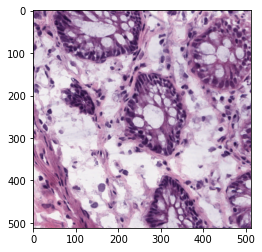

In [ ]:
i = 10130
i = 2000
i = 4700

print(train_set.labels[i])
print(train_set.case_ids[i])
plt.imshow(train_set.inputs[i])
plt.show()

In [ ]:
for i, x in enumerate(train_set.case_ids):
    print(np.argmax(train_set.labels[i]), train_set.case_ids[i]) 

1 X_TCGA-AA-3976-01A_0
1 X_TCGA-AA-3976-01A_1
1 X_TCGA-AA-3976-01A_2
1 X_TCGA-AA-3976-01A_3
1 X_TCGA-AA-3976-01A_4
1 X_TCGA-AA-3976-01A_5
1 X_TCGA-AA-3976-01A_6
1 X_TCGA-AA-3976-01A_7
1 X_TCGA-AA-3976-01A_8
1 X_TCGA-AA-3976-01A_9
1 X_TCGA-AA-3976-01A_10
1 X_TCGA-AA-3976-01A_11
1 X_TCGA-AA-3976-01A_12
1 X_TCGA-AA-3976-01A_13
1 X_TCGA-AA-3976-01A_14
1 X_TCGA-AA-3976-01A_15
1 X_TCGA-AA-3976-01A_16
1 X_TCGA-AA-3976-01A_17
1 X_TCGA-AA-3976-01A_18
1 X_TCGA-AA-3976-01A_19
1 X_TCGA-AA-3976-01A_20
1 X_TCGA-AA-3976-01A_21
1 X_TCGA-AA-3976-01A_22
1 X_TCGA-AA-3976-01A_23
1 X_TCGA-AA-3976-01A_24
1 X_TCGA-AA-3976-01A_25
1 X_TCGA-AA-3976-01A_26
1 X_TCGA-AA-3976-01A_27
1 X_TCGA-AA-3976-01A_28
1 X_TCGA-AA-3976-01A_29
1 X_TCGA-AA-3976-01A_30
1 X_TCGA-AA-3976-01A_31
1 X_TCGA-AA-3976-01A_32
1 X_TCGA-AA-3976-01A_33
1 X_TCGA-AA-3976-01A_34
1 X_TCGA-AA-3976-01A_35
1 X_TCGA-AA-3976-01A_36
1 X_TCGA-AA-3976-01A_37
1 X_TCGA-AA-3976-01A_38
1 X_TCGA-AA-3976-01A_39
1 X_TCGA-AA-3976-01A_40
1 X_TCGA-AA-3976-01A_41
1 

IndexError: list index out of range

25ep0


c:\Users\Alejandro\Desktop\heterogeneous-data\src\WSI\plots.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


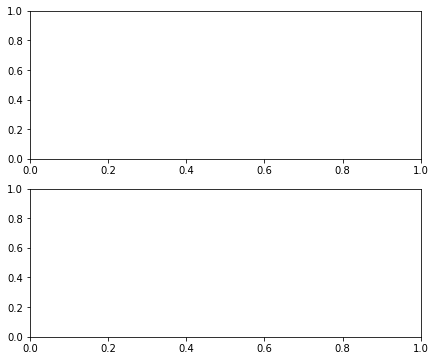

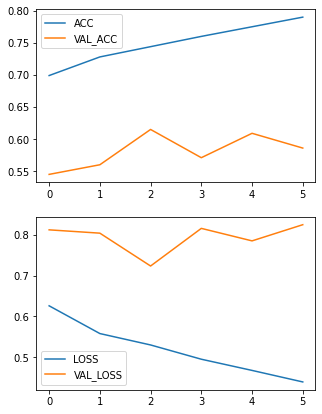

In [8]:
for SPLIT in range(1):
    NAME = EXP_NAME + f"{SPLIT}"
    print(NAME)
    learning_curve_train(NAME)